<h1 style="text-align:center;font-size:40px;">Tools 1 Final Project</h1>
<br>
<br>
<br>
<br>
<br>
<p style="text-align:center;">Anthony Molieri<br>
Leo Walker</p>
<br>
<br>
<br>
<br>

# Dataset and Motivation

The data used for these analyses were scraped from Indeed and Glassdoor. The data from Indeed contains job descriptions for open Data Scientist positions. The Glassdoor data includes employee generated ratings on benefits and perks for many of the companies present in the Indeed dataset. The datasets were then combined in order to give an idea of how employees rank the benefits at these companies.

*The Indeed data was scraped over ... pulling job descriptions for Data Scientists in 25 cities throughout the US. **Leo** Add Correct Details, here about the Indded data and scraper*

The Glassdoor scraper was designed to pull company names from the the job description dataset. It then looped over the list of employers, searched, and scraped ratings from the benefits page for companies that were found. This data was then added to it's own table in the same database. The scraper was designed to be run multiple times, only searching for benefits ratings that were not already present in the database. 

# Task Definition and Research Question
 
The purpose of this project was to help give a better idea of how employees at companies with open positions rate their benefits. This can help give insight into how desirable a company is as an employer.

# Literature Review

*Add -- I'm not really sure what to add here. Maybe something about turnover in data science? Companies not having great benefits?*

# Data Cleaning

In [1]:
# imports
import numpy as np
import pandas as pd
import sqlite3
import re
import seaborn as sns

from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import nlp_processing

In [2]:
# Initialize both tables
cnct = sqlite3.connect('Data/jobs')

indeed_df = pd.read_sql_query('SELECT * FROM indeed_jobs;', cnct)
indeed_df.drop('est salary', axis=1, inplace=True)

glassdoor_df = pd.read_sql_query('SELECT companies, type, rating, count_of_ratings FROM ratings;', cnct)

## Cleaning Indeed Data

In [3]:
# While we were able to get the estimated salary from the job scraping we can see if there was any job salaries within the job description
def salary_extract(row):
    if row['est_salary']!="No Estimated Salary":
        return row['est_salary']
    else:
        pattern = r"\$([0-9]{5,6}|[0-9]{2,3},[0-9]{3})"
        found = re.findall(pattern, row['job_desc'])
        if len(found)==1:
            return f'{found[0]} a year'
        elif len(found)>1:
            return f'{found[0]} - {found[1]} a year'
        else:
            return None

indeed_df['salary_extract'] = indeed_df.apply(salary_extract, axis=1)

In [4]:
# While we have the job title we need to categorize each job
def set_job_category(job_title):
    regex = re.compile('[^a-zA-Z]')
    clean_title = regex.sub('', job_title)
    clean_title = clean_title.lower()
    if all(x in clean_title for x in ["data", "scien"]):
        return "Data Scientist"
    elif all(x in clean_title for x in ["business", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["bi", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["data", "analy"]):
        return "Data Analyst"
    elif all(x in clean_title for x in ["machine", "learning"]):
        return "Machine Learning Engineer"
    elif all(x in clean_title for x in ["data", "engineer"]):
        return "Data Engineer"
    elif all(x in clean_title for x in ["software", "engin"]):
        return "Software Engineer"
    elif all(x in clean_title for x in ["architect"]):
        return "Data Architect"
    else:
        return "Other"

indeed_df['job_category'] = indeed_df.loc[:, 'job_title'].apply(set_job_category)

In [5]:
# Lets get the state from the company location so we can generalize them
indeed_df.loc[:,'state'] = indeed_df.loc[:, 'company_location'].str.extract(r', ([A-Z]{2})')

In [10]:
def salary_low(row):
    if row == None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    low = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return low

def salary_high(row):
    if row ==None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    if len(salary)>1:
        high = float(''.join(re.findall(pattern, salary[1])).replace(',',''))
    else:
        high = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return high

indeed_df['salary_low'] = indeed_df.loc[:,'salary_extract'].apply(salary_low)
indeed_df['salary_high'] = indeed_df.loc[:,'salary_extract'].apply(salary_high)

SyntaxError: invalid syntax (1677985954.py, line 2)

In [8]:
indeed_df.loc[:,'salary_extract'].apply(salary_low)

NameError: name 'salary_low' is not defined

In [18]:
# We noticed that the pay rate varies between annual, month, week, day, or hour. 
def pay_rate(row):
    if row ==None:
        return None
    regex = re.compile('[.[0-9]]')
    clean_salary = regex.sub('', row)
    clean_salary = clean_salary.lower()
    if any(x in clean_salary for x in ["year"]):
        return "annual"
    elif any(x in clean_salary for x in ["month"]):
        return "month"
    elif any(x in clean_salary for x in ["week"]):
        return "week"
    elif any(x in clean_salary for x in ["day"]):
        return "day"
    elif any(x in clean_salary for x in ["hour"]):
        return "hour"
    else:
        return "Other"

indeed_df['pay_rate'] = indeed_df.loc[:, 'salary_extract'].apply(pay_rate)

KeyError: "['salary_low', 'salary_high'] not in index"

In [ ]:
def calc_salary(row):
    # print(row)
    pay_rate=row['pay_rate']
    if (pay_rate == 'Other') or (pay_rate==None):
        return None

    rate_change= {'annual':1, 'month':12, 'week':52, 'day':260, 'hour':2080}
    est_annual_salary = ((row['salary_low']+row['salary_high'])/2)*rate_change[pay_rate]
    return est_annual_salary
indeed_df['est_annual_salary'] = indeed_df.loc[:,['salary_low','salary_high','pay_rate']].apply(calc_salary, axis=1)

In [ ]:
indeed_df[indeed_df['est_salary']!='No Estimated Salary'].sample(4)

,index,job_title,company_name,company_location,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
12694,12,Business and Data Analyst,NYC Careers,"Manhattan, NY 10007 (Financial District area)",https://www.indeed.com/rc/clk?jk=483e193c26609...,New York City Comptroller’s Burea...,"$90,000 - $100,000 a year",2022-04-03,"$90,000 - $100,000 a year",Business Intelligence Analyst,NY,90000.0,100000.0,annual,95000.0
10728,6,Senior Data Analyst,RetailData LLC,"Glen Allen, VA",https://www.indeed.com/rc/clk?jk=01812d71f0172...,About the Role: We are seeking a Senior Data A...,"$75,000 - $95,000 a year",2022-03-19,"$75,000 - $95,000 a year",Data Analyst,VA,75000.0,95000.0,annual,85000.0
13377,11,Sr. Data Scientist/Machine Learning Engineer,DISYS,"Dallas, TX",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Job Title: - Sr Data Scientist / or ML Engine...,"$130,000 - $170,000 a year",2022-04-04,"$130,000 - $170,000 a year",Data Scientist,TX,130000.0,170000.0,annual,150000.0
5538,5,Sr. Data Engineer,Southside Bank,"Austin, TX 78746",https://www.indeed.com/rc/clk?jk=c25d1e52cfbb1...,Position Title: Sr. Data Engineer FLSA Status:...,"$100,000 - $115,000 a year",2022-02-26,"$100,000 - $115,000 a year",Data Engineer,TX,100000.0,115000.0,annual,107500.0


# Visualizations

Lets start by looking at average salary by state and job category

In [ ]:
# Lets see what states share their salary the most
salary_by_job_state_count = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category', 'state'])['est_annual_salary'].count().reset_index()
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='state', y='est_annual_salary', data=salary_by_job_state_count, estimator=sum,ci=None)

In [ ]:
salary_by_job_state_mean = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category'])['est_annual_salary'].mean().reset_index()
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='job_category', y='est_annual_salary', data=salary_by_job_state_mean)

In [ ]:
salary_by_job_state_mean = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category', 'state'])['est_annual_salary'].mean().reset_index()
sns.set(rc={'figure.figsize':(30,12)})
ax = sns.barplot(x='job_category', y='est_annual_salary', hue='state', data=salary_by_job_state_mean)

In [107]:
indeed_df[indeed_df.state == 'ON']

,index,job_title,company_name,company_location,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
8736,14,Data Analyst 3,Zynga,"Temporarily Remote in Toronto, ON",https://www.indeed.com/rc/clk?jk=79baf1e8177d9...,Zynga is a leading developer of the world’s mo...,No Estimated Salary,2022-03-14,None,Data Analyst,ON,NaN,NaN,None,NaN


In [119]:
# corpus = list(indeed_df['job_desc'])
# clean_corpus = [nlp_processing.process_string(doc) for doc in corpus]

In [123]:
# np.random.seed(12345)
# working_corpus = clean_corpus.copy()
# vectorizer, vocabulary = nlp_processing.build_text_vectorizer(working_corpus,
#                              use_tfidf=True,
#                              max_features=2000)
# word_mat = vectorizer(working_corpus)

# # Find latent topics using our NMF model.
# factorizer = NMF(n_components=7, alpha=0.5, l1_ratio=0.1, verbose=0)
# W = factorizer.fit_transform(word_mat)
# H = factorizer.components_

c:\Users\leowa\anaconda3\envs\JobsNLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\leowa\anaconda3\envs\JobsNLP\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Users\leowa\anaconda3\envs\JobsNLP\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [124]:
# for i, row in enumerate(H):
#         num_words = np.argsort(row)[::-1][:50]
#         print ('Topic', i)
#         print (' '.join(vocabulary[num_words]), '\n')

Topic 0
project process management information analyst application program analysis development ensure need plan user knowledge technical department perform develop technology issue andor procedure assist documentation manage financial meet communication maintain improvement analyze duty level design research policy identify activity review standard functional lead organization strong staff test relate quality assign function 

Topic 1
machine learning engineer software engineering technology ml design science cloud model development platform learn aws datum amazon pipeline code scientist algorithm technical computer ai python develop architecture infrastructure scale security language application production deep problem vmware deploy feature java programming azure framework lead test spark processing scalable tool solve large 

Topic 2
accenture accommodation disclose compensation observance colorado authorization cloud information investigation recruiting reasonable minimum continue 

In [125]:
# labels = W.argmax(axis=1)
# for i in range(0, W.shape[1]):
#     print ("Topic {} contains {} documents.".format(i, np.sum(labels == i)))

Topic 0 contains 5998 documents.
Topic 1 contains 5022 documents.
Topic 2 contains 310 documents.
Topic 3 contains 4961 documents.
Topic 4 contains 318 documents.
Topic 5 contains 336 documents.
Topic 6 contains 241 documents.


In [132]:
# indeed_df.job_category.unique()
# label_dict = {'Data Scientist':0, 'Machine Learning Engineer': 2, 'Data Analyst':3, 'Business Intelligence Analyst':4,
#          'Data Engineer':5, 'Data Architect':6, 'Software Engineer':7,'Other':8}
        

In [135]:
# indeed_df['num_labels'] = indeed_df['job_category'].map(label_dict)
# real_labels = indeed_df['num_labels'].ravel()

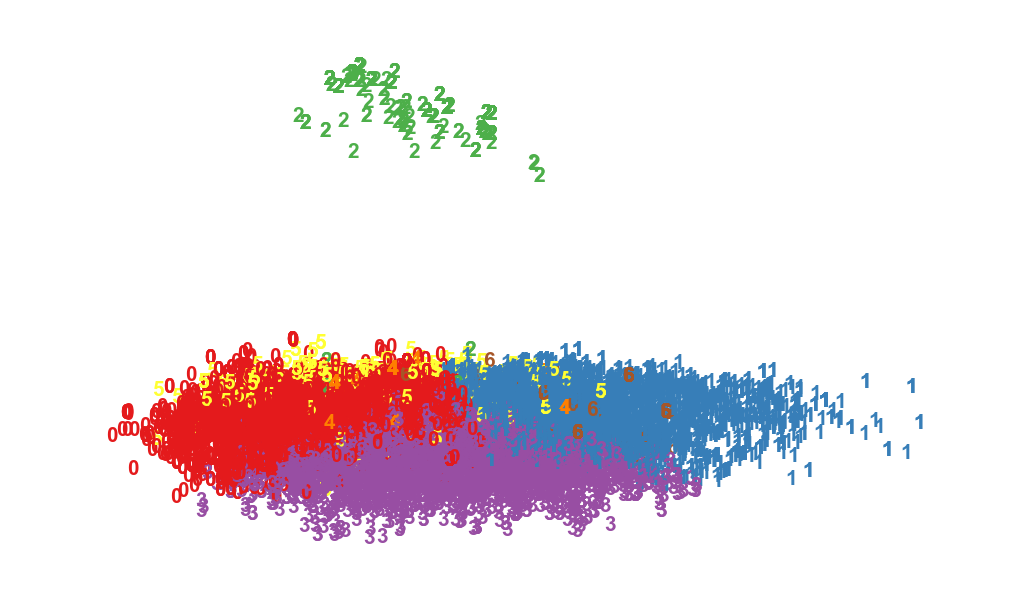

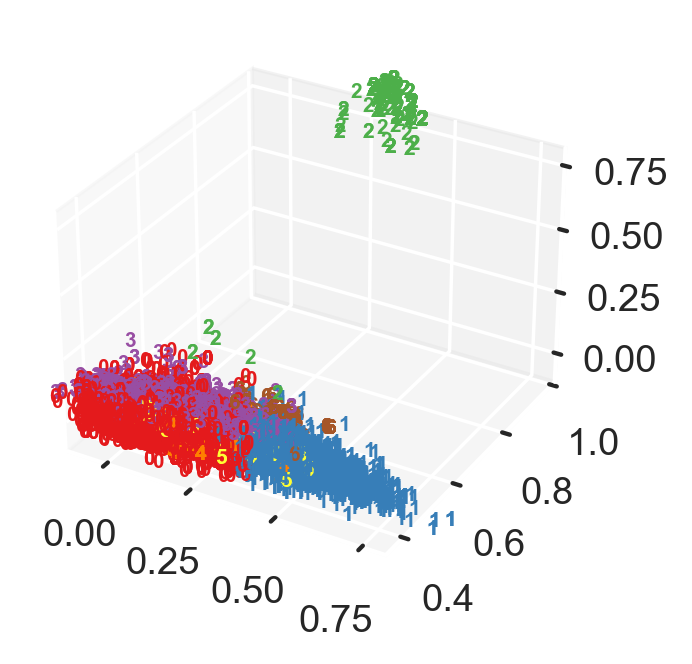

In [140]:
# 